In [7]:
# This program uses an artificial recurrent neural network called long short term memory (LSTM) to predict the closing 
# of a corporation (I will be using TSLA Inc.) using the past 60 day stock price

NN

In [8]:
# import the libraries needed
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
# Get the Stock Quote
df = web.DataReader("TSLA", data_source="yahoo", start="2012-01-01", end = "2022-09-20")
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,1.966667,1.843333,1.929333,1.872000,13921500.0,1.872000
2012-01-04,1.911333,1.833333,1.880667,1.847333,9451500.0,1.847333
2012-01-05,1.862000,1.790000,1.850667,1.808000,15082500.0,1.808000
2012-01-06,1.852667,1.760667,1.813333,1.794000,14794500.0,1.794000
2012-01-09,1.832667,1.741333,1.800000,1.816667,13455000.0,1.816667
...,...,...,...,...,...,...
2022-09-14,306.000000,291.640015,292.239990,302.609985,72628700.0,302.609985
2022-09-15,309.119995,300.720001,301.829987,303.750000,64795500.0,303.750000
2022-09-16,303.709991,295.600006,299.609985,303.350006,86949500.0,303.350006


In [ ]:
# Get the number of rows and columns in the dataset
df.shape

NameError: name 'df' is not defined

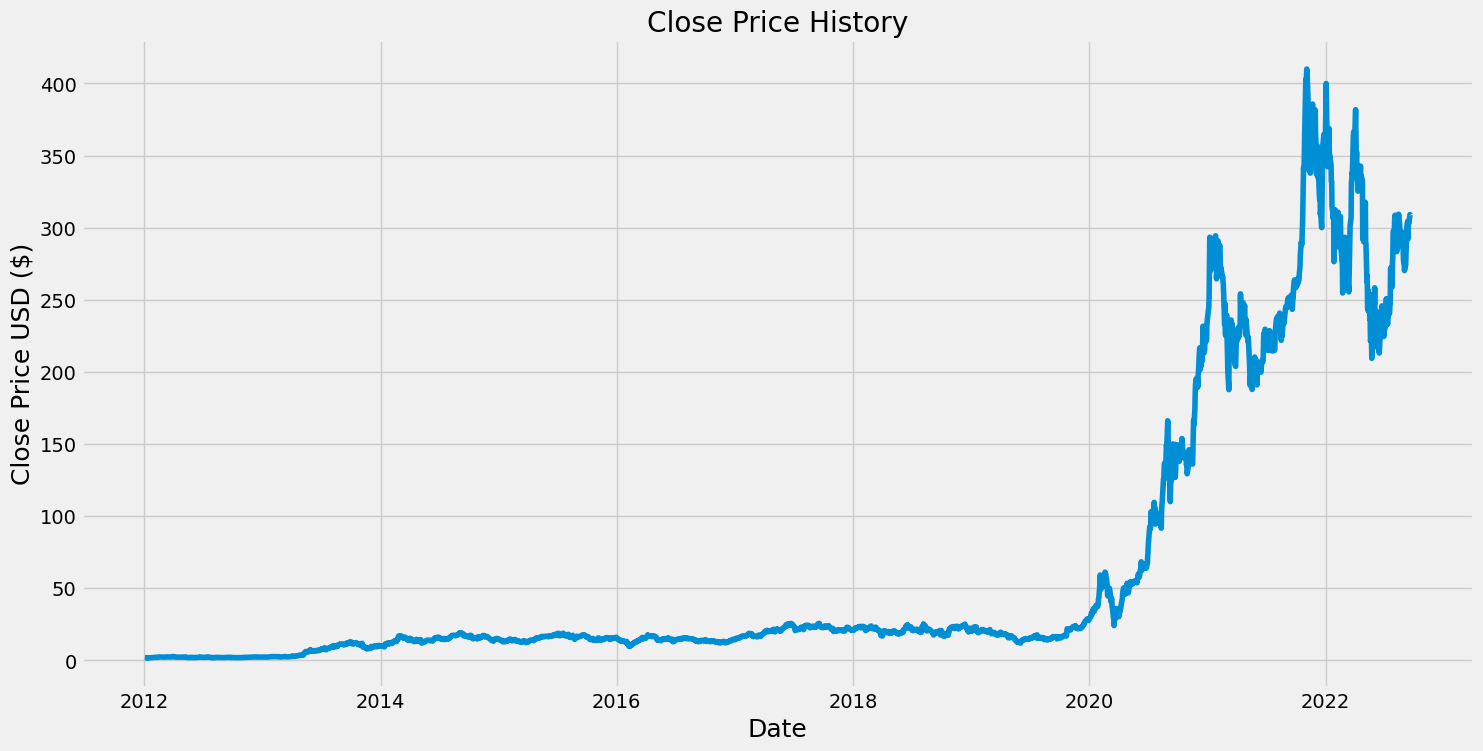

In [ ]:
# Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title("Close Price History")
plt.plot(df["Close"])
plt.xlabel("Date", fontsize = 18)
plt.ylabel("Close Price USD ($)", fontsize = 18)
plt.show()

In [ ]:
# Create a new datafram with only close column
data = df.filter(["Close"])
# covert dataframe to numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = math.ceil(len(dataset)*0.8)
print(training_data_len)

2158


In [ ]:
#Scale the data
# applying preprocessing
scaler = MinMaxScaler(feature_range=(0,1)) # scales the data with min 0 max 1, (i.e minimum value in dataset becomes 0, max becomes 1 rest are scaled according)
scaled_data = scaler.fit_transform(dataset) 
scaled_data

array([[8.63426116e-04],
       [8.03034430e-04],
       [7.06736421e-04],
       ...,
       [7.38964817e-01],
       [7.52968959e-01],
       [7.52136554e-01]])

In [ ]:
# Create the training dataset
# Create the scaled training dataset
train_data = scaled_data[0:training_data_len, :]
# split data into x_train and y_train
x_train = []
y_train = []
for i in range(60, len(train_data)):
    # per pass through, x_train will take first 60 values, and y will take 61st (i.e will use 60 values for predicting target 61st value)
    x_train.append(train_data[i-60:i, 0]) 
    y_train.append(train_data[i,0])

In [ ]:
#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)


In [ ]:
#Reshape the data, LSTM model expects 3 dim
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [ ]:
# Build the LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape= (x_train.shape[1],1)    ))
model.add(LSTM(50,return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [ ]:
model.compile(optimizer="adam", loss = "mean_squared_error")

In [ ]:
#Train the model
model.fit(x_train,y_train, batch_size=1, epochs=1)

2098/2098 [==============================] - 31s 14ms/step - loss: 1.0934e-04


In [ ]:
#Create the testing data set
# Create a new array containing scaled values from 1543 to 2003
test_data = scaled_data[training_data_len-60: , :]
#Create the datasets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

In [ ]:
# convert data to numpy array
x_test = np.array(x_test)


In [ ]:
#reshape data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))


In [ ]:
#Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions) # reverse scale the predictions


17/17 [==============================] - 1s 9ms/step


In [ ]:
#Get the root MSE 
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

11.795765156648597

C:\Users\Karanpal Sekhon\AppData\Local\Temp\ipykernel_17984\3611443382.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid["Predictions"] = predictions


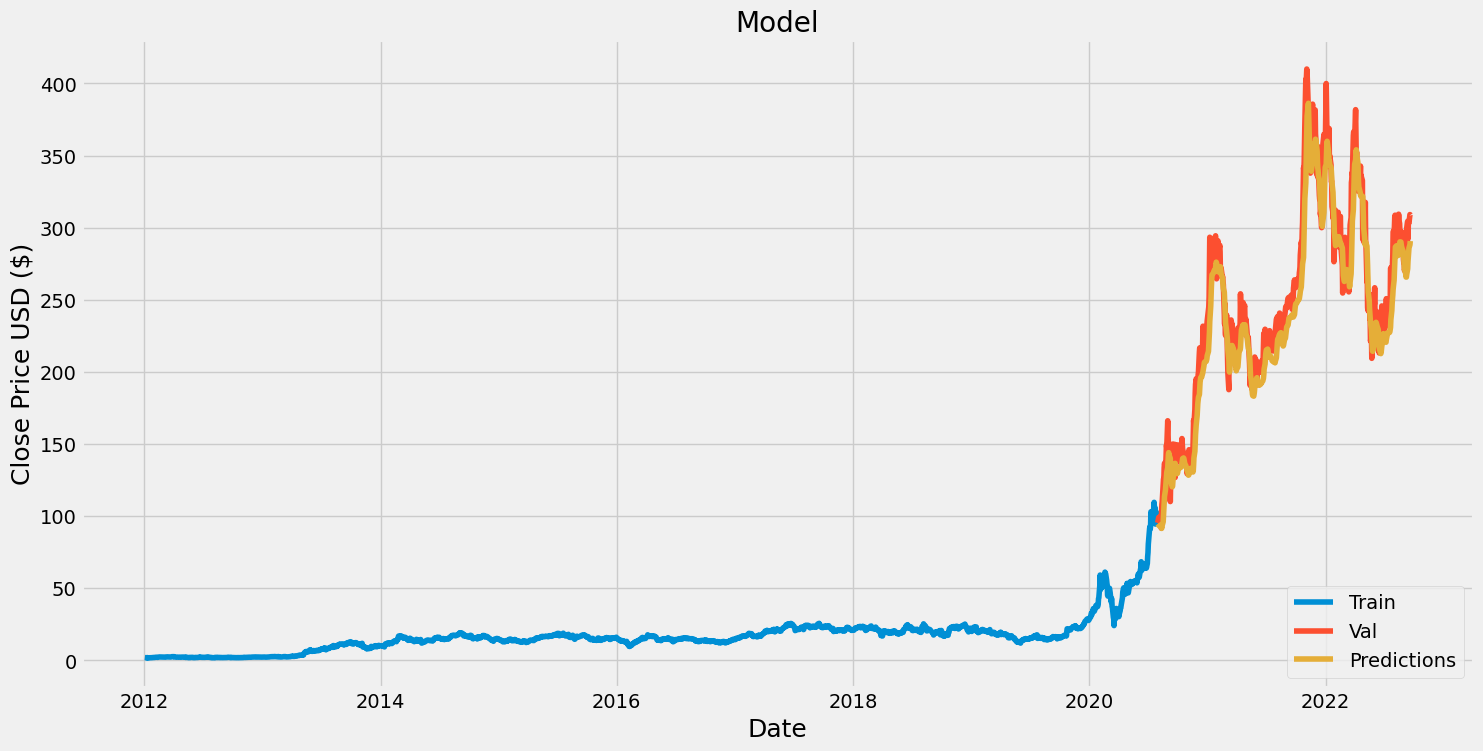

In [ ]:
# plt the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid["Predictions"] = predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title("Model")
plt.xlabel("Date", fontsize = 18)
plt.ylabel("Close Price USD ($)", fontsize = 18)
plt.plot(train["Close"])
plt.plot(valid[["Close", "Predictions"]])
plt.legend(["Train", "Val", "Predictions"], loc = "lower right")
plt.show()